### Goal
Find genes which have low expression and low variance across data

### TODO
- compute per gene the variance and median
- visualize the data
- check if there are tissue enhanced gene expression (observe the expression only in one tissue)

In [3]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math

import rep.preprocessing as p

#### 1. Compute gene variance

In [64]:
# load gtex summarized experiment
file = os.path.join("..","..","data","processed","gtex","recount","recount_gtex.h5ad")
gtex = p.load(file)

In [41]:
gtex_anno=gtex.obs
del gtex

In [77]:
stats=pd.DataFrame()
stats["mean"]=gtex.X.mean(axis=1)
stats["Std.Dev"]=gtex.X.std(axis=1)
stats["Var"]=gtex.X.var(axis=1)
stats["median"]=np.zeros(stats["Var"].shape)

In [96]:
for i in range(stats["Var"].shape[0]):
    stats["median"][i] = np.median(gtex.X[i,:])

/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
# per sample
stats["mean"].shape

(58037,)

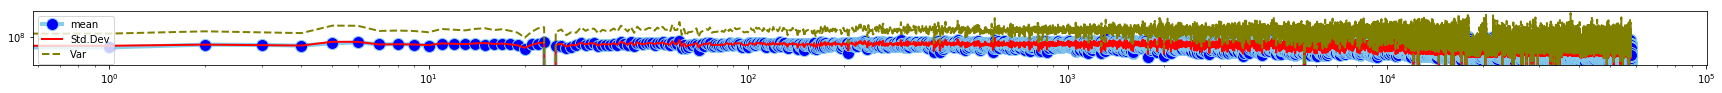

In [29]:
plt.figure(figsize=(30,1))
plt.loglog( stats.index, stats['mean'], marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.loglog( stats.index, stats['Std.Dev'], marker='', color='red', linewidth=2)
plt.loglog( stats.index, stats['Var'], marker='', color='olive', linewidth=2, linestyle='dashed')
plt.legend()

In [42]:
min_gtex = np.argmax(stats["mean"])
gtex_anno.iloc[17911,:]

gene_id      ENSG00000198804.2
bp_length                 1542
symbol                    COX1
Name: ENSG00000198804.2, dtype: object

/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb76ef108d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb76ef10f60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb76ef10780>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb76ef19630>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb76ef19978>],
 'means': []}

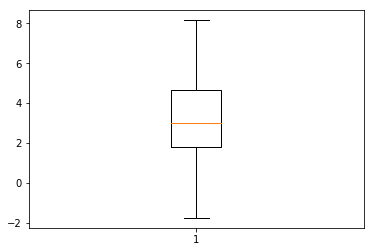

In [45]:
plt.boxplot(np.log10(stats['mean']))

/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


(-2, 10)

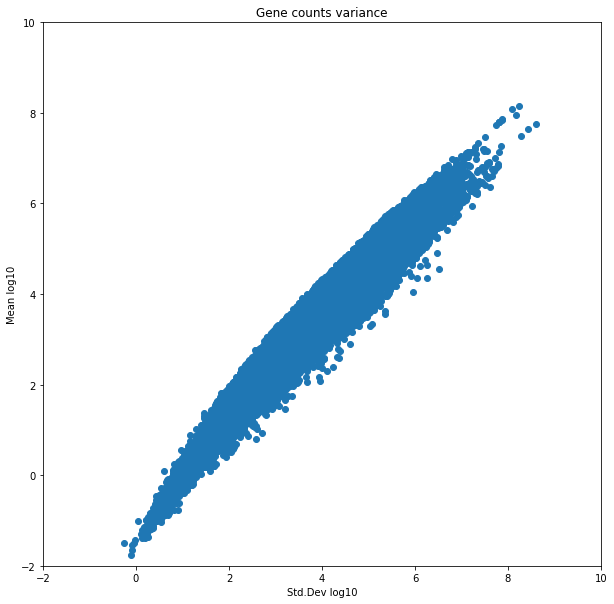

In [53]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(stats['Std.Dev']), np.log10(stats['mean']))
plt.title('Gene counts variance')
plt.xlabel('Std.Dev log10')
plt.ylabel('Mean log10')
plt.xlim(-2, 10)
plt.ylim(-2, 10)

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(stats['Std.Dev']), np.log10(stats['median']))
plt.title('Gene counts variance')
plt.xlabel('Std.Dev log10')
plt.ylabel('Median log10')
plt.xlim(-2, 10)
plt.ylim(-2, 10)

In [60]:
# count genes which have a mean <= 100x and variance <= 100x

stats[(stats["mean"] <= 100) & (stats["Std.Dev"] <= 100)].shape

(10348, 3)

In [68]:
import scanpy.api as sc
import scanpy

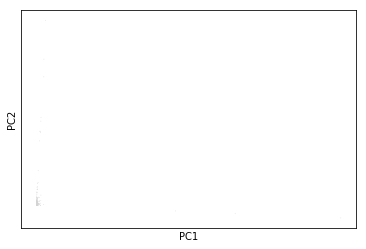

In [70]:
sc.tl.pca(gtex)
sc.pl.pca_scatter(gtex)

In [71]:
scanpy.logging.print_memory_usage()

Memory usage: current 3.21 GB, difference +3.21 GB


#### Compute blood to other tissues

In [97]:
file = os.path.join("..","..","data","processed","gtex","recount","recount_gtex.h5ad")
gtex = p.load(file)

In [5]:
# load gtex summarized experiment
file = os.path.join("..","..","data","processed","gtex","recount","recount_gtex.h5ad")
gtex = p.load(file)

# load invidivudals
path = os.path.join("..","..","data","processed","gtex","recount")

train = []
valid = []
test = []
states = ['train','valid','test']
dict_states_indiv = {'train':train,'valid':valid,'test':test}

for s in states:
    with open(os.path.join(path,s+"_individuals.txt"), 'r') as f:
        for l in f: dict_states_indiv[s].append(l.replace("\n",""))
            
# remove genes with no counts accross all tissues and invididuals
zero_elem = np.where(~gtex.X.any(axis=1))[0]

# remove noncoding genes
protein_coding = []
with open(os.path.join("..","..","data","raw","annotation","gencode_v25_protein_coding_genes.txt")) as f:
    for line in f: protein_coding.append(line.replace("\n","").split(".")[0])

tokeep = [gene for i,gene in enumerate(gtex.obs_names) if i not in zero_elem and gene.split(".")[0] in protein_coding]
filtered_gtex = gtex[tokeep]
del gtex, zero_elem

# select features for the model - reduce number of feature is for debugging purpose
# selected_genes = filtered_gtex.obs_names[:1000]
selected_genes = filtered_gtex.obs_names # training with all features
print("Total Genes: ",len(selected_genes))


Total Genes:  19932


In [15]:
# compute cross tissue matrix
# %time (X_train, Y_train, samples_description_train, gene_id_train) = p.rnaseq_cross_tissue(filtered_gtex, individuals=train, gene_ids=selected_genes, input_transform='log10')
%time (X_valid, Y_valid, samples_description_valid, gene_id_valid) = p.rnaseq_cross_tissue(filtered_gtex, individuals=valid, gene_ids=selected_genes, input_transform='log10', onlyBlood = True)
# %time (X_test, Y_test, samples_description_test, gene_id_test) = p.rnaseq_cross_tissue(filtered_gtex, individuals=test, gene_ids=selected_genes, 

samples_df  (8911, 14)
samples_df_sliced  (1820, 14)
compute all arrangements
Total pairs: 1630
CPU times: user 1min 10s, sys: 59.7 s, total: 2min 10s
Wall time: 37.5 s
